In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

Here we use a k-nearest neighbor model to interpolate the SCRAM tables, and to create functions that output opacity and emissivity given any temp. and density. The SCRAM tables sholuld have already been processed and converted using LoadSCRAM.ipynb

In [3]:
# Show emissivity and opacity

E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV
emi = np.load('./Al-MARZ2_scram_tables/emi_scram.npy') # W/eV/cm^-3
opa = np.load('./Al-MARZ2_scram_tables/opa_scram.npy') # cm^-1
values = np.load('./Al-MARZ2_scram_tables/values_scram.npy') # denisty cm^-3 and Te eV

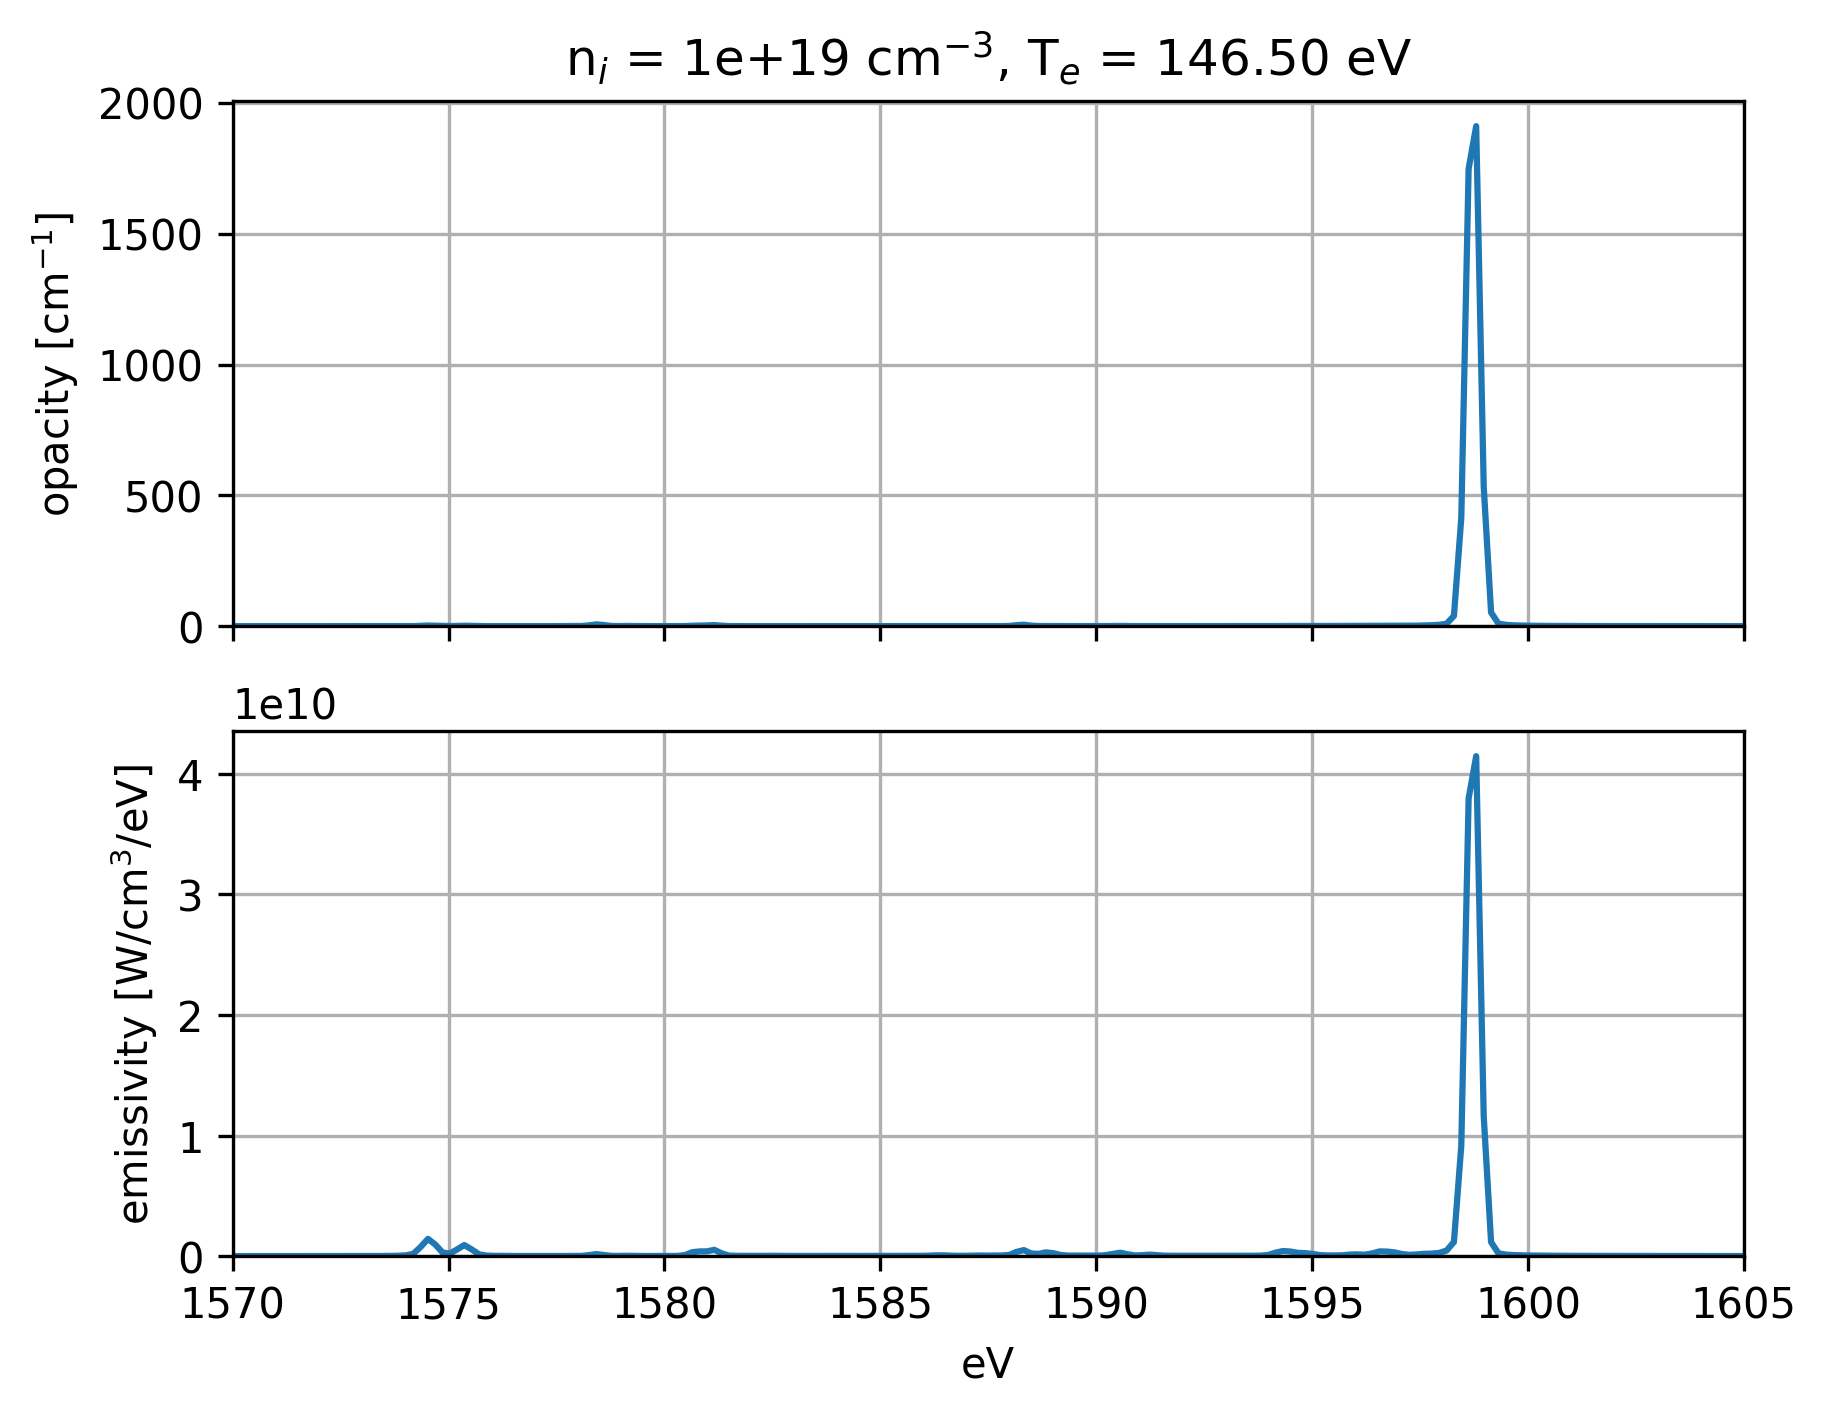

In [4]:
# Show opacity and emissivity for a given temp. and density 

ni = 1e19
Te = 1.465E+02

idx = np.argwhere((values[:,0] == ni) & (values[:,1] == Te))

fig, axs = plt.subplots(2,1,figsize=(6.5,5),dpi=300,sharex=True)
axs[0].plot(E,np.squeeze(opa[idx,:]))
axs[1].plot(E,np.squeeze(emi[idx,:]))

for ii in range(axs.shape[0]):
    axs[ii].grid()
    axs[ii].set_ylim(ymin=0)
    axs[ii].set_xlim([1570,1605])

axs[1].set_xlabel('eV')
axs[0].set_ylabel('opacity [cm$^{-1}$]')
axs[1].set_ylabel('emissivity [W/cm$^{3}$/eV]')
axs[0].set_title('n$_i$ = %1.3g cm$^{-3}$, T$_e$ = %1.2f eV' % (ni,Te))
plt.show()


In [39]:
# Split dataset into test, train and validation
# 

E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV
y_emi = np.load('./Al-MARZ2_scram_tables/emi_scram.npy') # W/eV/cm^-3
y_opa = np.load('./Al-MARZ2_scram_tables/opa_scram.npy') # cm^-1
x = np.load('./Al-MARZ2_scram_tables/values_scram.npy') # denisty cm^-3 and Te eV
n_list = np.loadtxt('./Al-MARZ2_scram_tables/ni.txt')
T_list = np.loadtxt('./Al-MARZ2_scram_tables/Te.txt')

def scale(x): # Scale the data, here we use a log scale for both temp. adn density
    x[:,0] = (np.log10(x[:,0]) - np.log10(n_list.min())) / (np.log10(n_list.max()) - np.log10(n_list.min())) # scale denisty
#     x[:,1] = (x[:,1] - T_list.min()) / (T_list.max()-T_list.min()) # scale temp.?(linear)
    x[:,1] = (np.log10(x[:,1]) - np.log10(T_list.min())) / (np.log10(T_list.max()) - np.log10(T_list.min())) # scale temp. log
    return x

x_scale = scale(x) # scaled x

from sklearn.model_selection import train_test_split


x_tv, x_test, y_tv, y_test = train_test_split(x_scale, y_emi, test_size=0.1, random_state=56)
x_train, x_val, y_train, y_val = train_test_split(x_tv, y_tv, test_size=0.1, random_state=100)

print('Shape of training set:')
print('x:', x_train.shape)
print('y:',  y_train.shape)
print('Shape of validation set:')
print('x:', x_val.shape)
print('y:',  y_val.shape)
print('Shape of test set:')
print('x: ',  x_test.shape)
print('y: ',  y_test.shape)


Shape of training set:
x: (116, 2)
y: (116, 1199)
Shape of validation set:
x: (13, 2)
y: (13, 1199)
Shape of test set:
x:  (15, 2)
y:  (15, 1199)


k =  2
Coeff. of Determination (R2) =74.63778133066589%
k =  3
Coeff. of Determination (R2) =74.08313381466331%
k =  4
Coeff. of Determination (R2) =64.64009176692659%
k =  5
Coeff. of Determination (R2) =62.87731711720534%
k =  6
Coeff. of Determination (R2) =58.33390809596673%
k =  7
Coeff. of Determination (R2) =54.34748093258598%
k =  8
Coeff. of Determination (R2) =50.87769781549103%


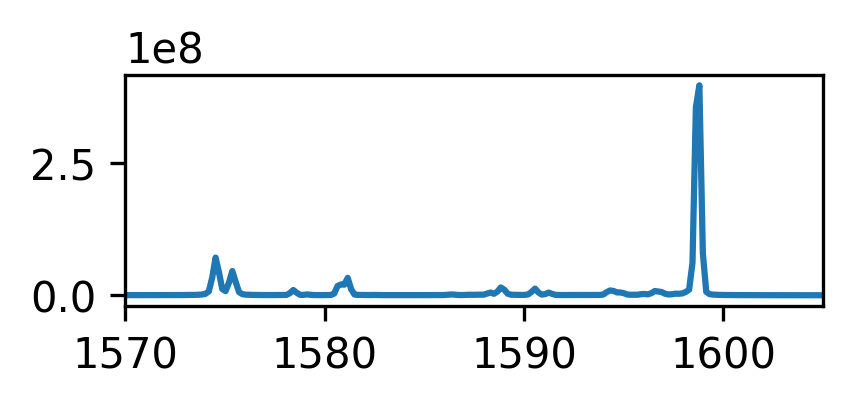

In [40]:
# try a k-nearest neighnor regression model
from sklearn.neighbors import KNeighborsRegressor

for ii in range(2,9):
    print('k = ', ii)
    knr = KNeighborsRegressor(n_neighbors=ii,weights='distance')
    knr.fit(x_train,y_train)
    score = knr.score(x_val,y_val)
    print('Coeff. of Determination (R2) =' + str(100*score) + '%')
    if ii == 2:
        knrbest = knr;
        scorebest = score;
    else:
        if score > scorebest:
            knrbest = knr;
    

def scale_ni(x):
    return (np.log10(x)-np.log10(n_list.min())) / (np.log10(n_list.max()) - np.log10(n_list.min()))

def scale_T(x):
#     return (x-T_list.min()) / (T_list.max()-T_list.min()) # linear
    return (np.log10(x)-np.log10(T_list.min())) / (np.log10(T_list.max()) - np.log10(T_list.min()))

def descale_ni(x):
    return np.around(10**((np.log10(n_list.max()) - np.log10(n_list.min())) * x + np.log10(n_list.min())),decimals=3)

def descale_T(x):
#     return np.round(x * (T_list.max()-T_list.min()) + T_list.min(),decimals=2) # linear
    return np.around(10**((np.log10(T_list.max()) - np.log10(T_list.min())) * x + np.log10(T_list.min())),decimals=2)


out = knrbest.predict(np.array([[scale_ni(1e19),scale_T(100)]]))

fig,axs = plt.subplots(1,1,figsize=(3,1),dpi=300)
axs.plot(E,out[0])
axs.set_xlim([1570,1605])

plt.show()

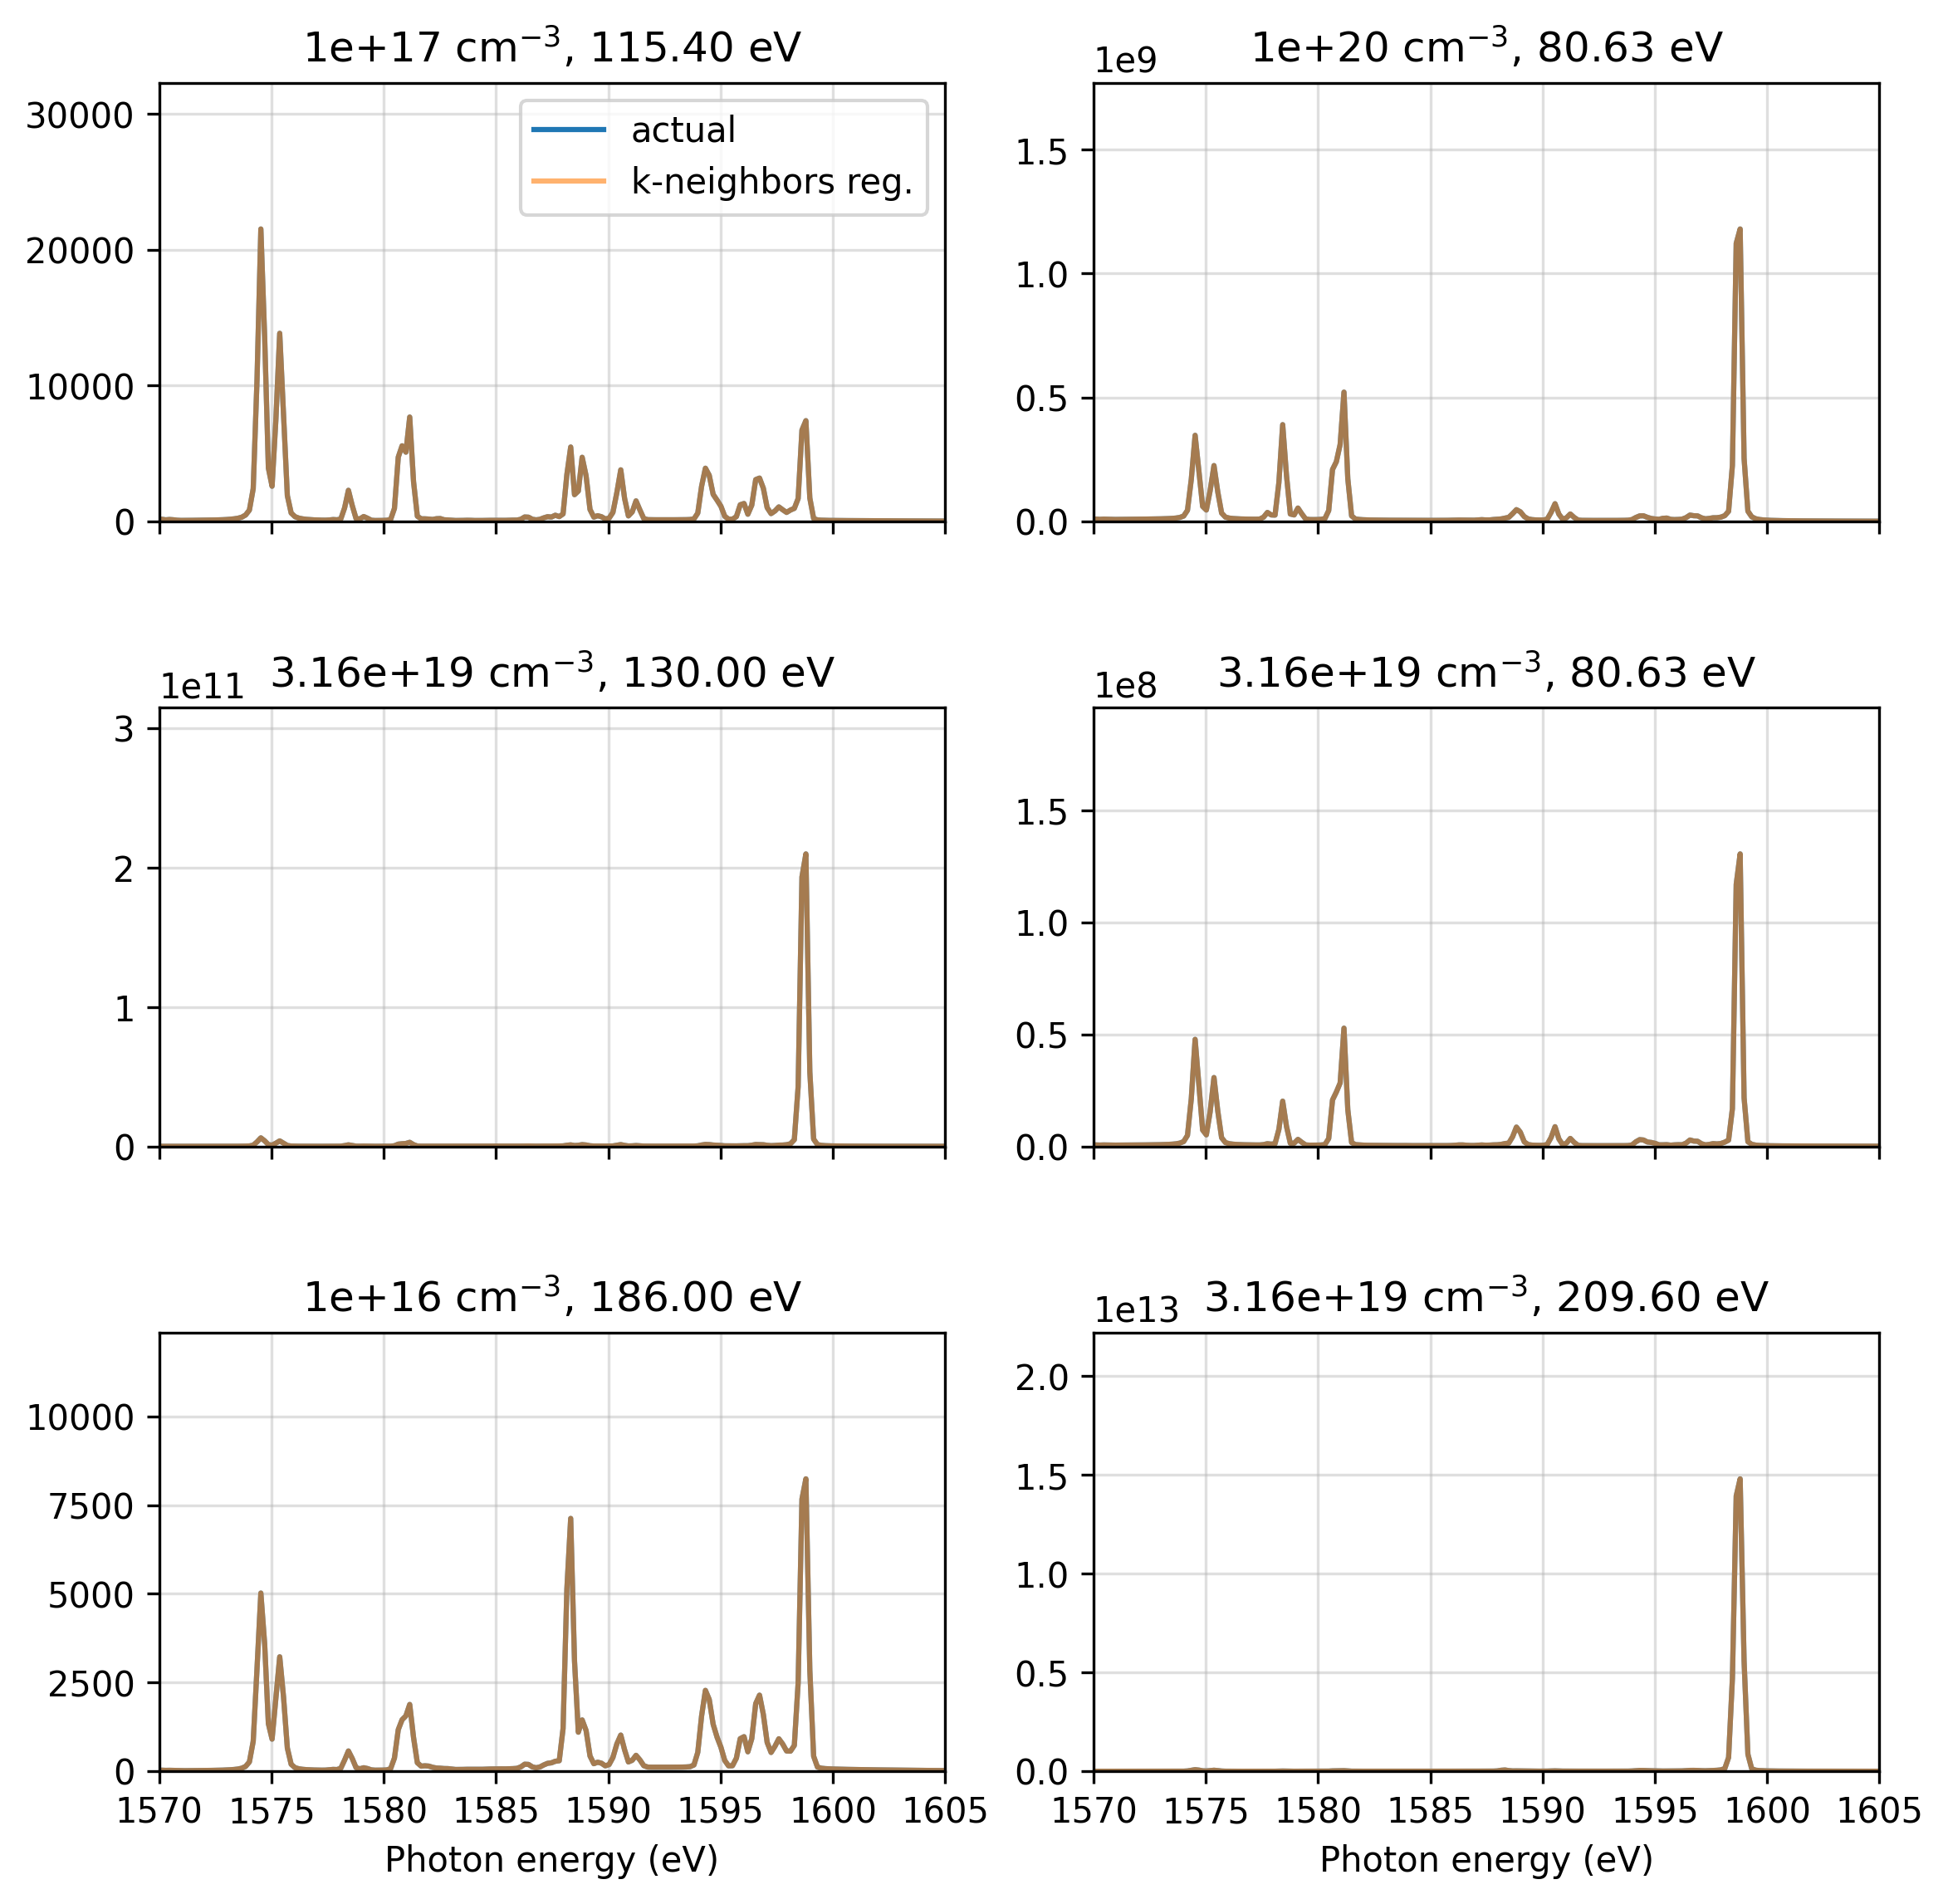

In [41]:
# compare with train set
idx = np.random.randint(0,x_train.shape[0]-1,6) # random indices within (scaled) test set

fig,axs = plt.subplots(3,2,figsize=(8,8),dpi=300,sharex=True)
for ii in range(idx.shape[0]):
    emi = y_train[idx[ii],:]
    axs[ii % 3, ii // 3].plot(E,emi,label='actual')
    
    out = knrbest.predict(np.array([[x_train[idx[ii],0],x_train[idx[ii],1]]]))
    axs[ii % 3, ii // 3].plot(E,out[0],label='k-neighbors reg.',alpha=0.6)
    
    axs[ii % 3, ii // 3].set_title('%0.3g cm$^{-3}$, %0.2f eV' % (descale_ni(x_train[idx[ii],0]),descale_T(x_train[idx[ii],1])))
    axs[ii % 3, ii // 3].set_ylim([0,1.5*out[0].max()])
    axs[ii % 3, ii // 3].grid(alpha=0.4)
    axs[ii % 3, ii // 3].set_xlim([1570,1605])
axs[-1,0].set_xlabel('Photon energy (eV)')
axs[-1,1].set_xlabel('Photon energy (eV)')
fig.tight_layout(pad=2.0)
axs[0,0].legend()
plt.show()    

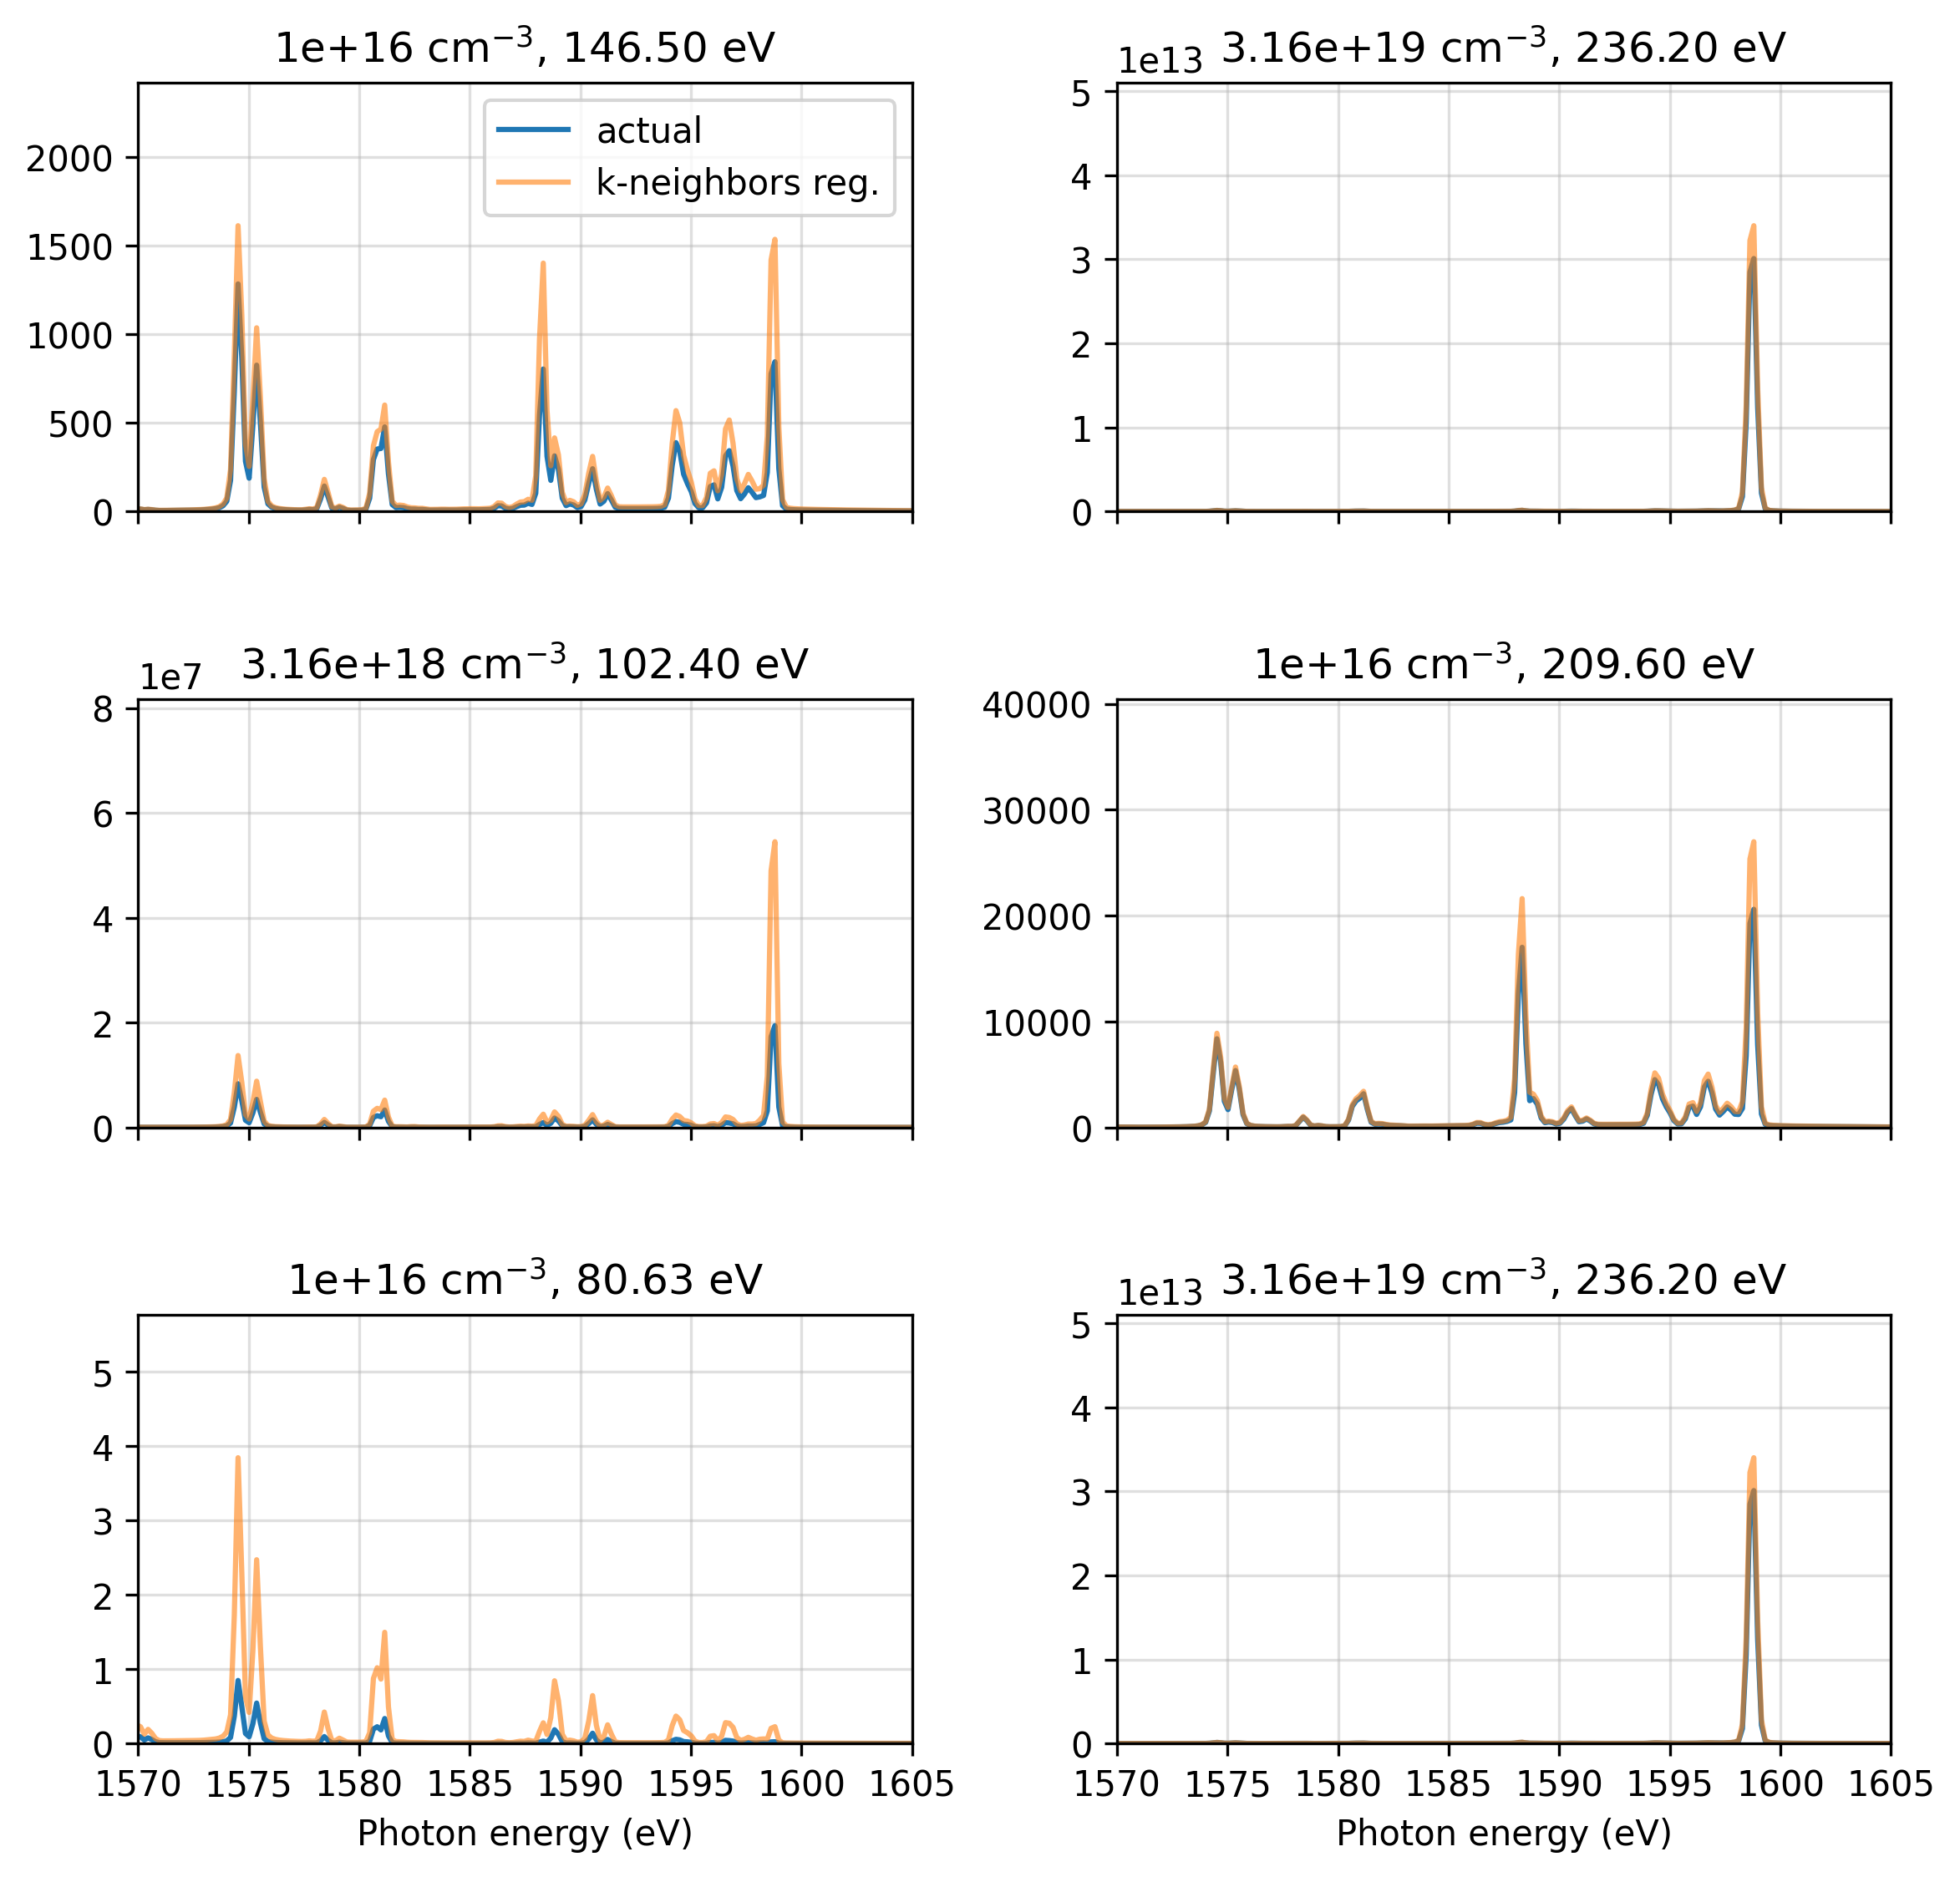

In [42]:
# compare with test set
idx = np.random.randint(0,x_test.shape[0]-1,6) # random indices within (scaled) test set

fig,axs = plt.subplots(3,2,figsize=(8,8),dpi=300,sharex=True)
for ii in range(idx.shape[0]):
    emi = y_test[idx[ii],:]
    axs[ii % 3, ii // 3].plot(E,emi,label='actual')
    
    out = knrbest.predict(np.array([[x_test[idx[ii],0],x_test[idx[ii],1]]]))
    axs[ii % 3, ii // 3].plot(E,out[0],label='k-neighbors reg.',alpha=0.6)
    
    axs[ii % 3, ii // 3].set_title('%0.3g cm$^{-3}$, %0.2f eV' % (descale_ni(x_test[idx[ii],0]),descale_T(x_test[idx[ii],1])))
    axs[ii % 3, ii // 3].set_ylim([0,1.5*out[0].max()])
    axs[ii % 3, ii // 3].grid(alpha=0.4)
    axs[ii % 3, ii // 3].set_xlim([1570,1605])
axs[-1,0].set_xlabel('Photon energy (eV)')
axs[-1,1].set_xlabel('Photon energy (eV)')
fig.tight_layout(pad=2.0)
axs[0,0].legend()
plt.show()    

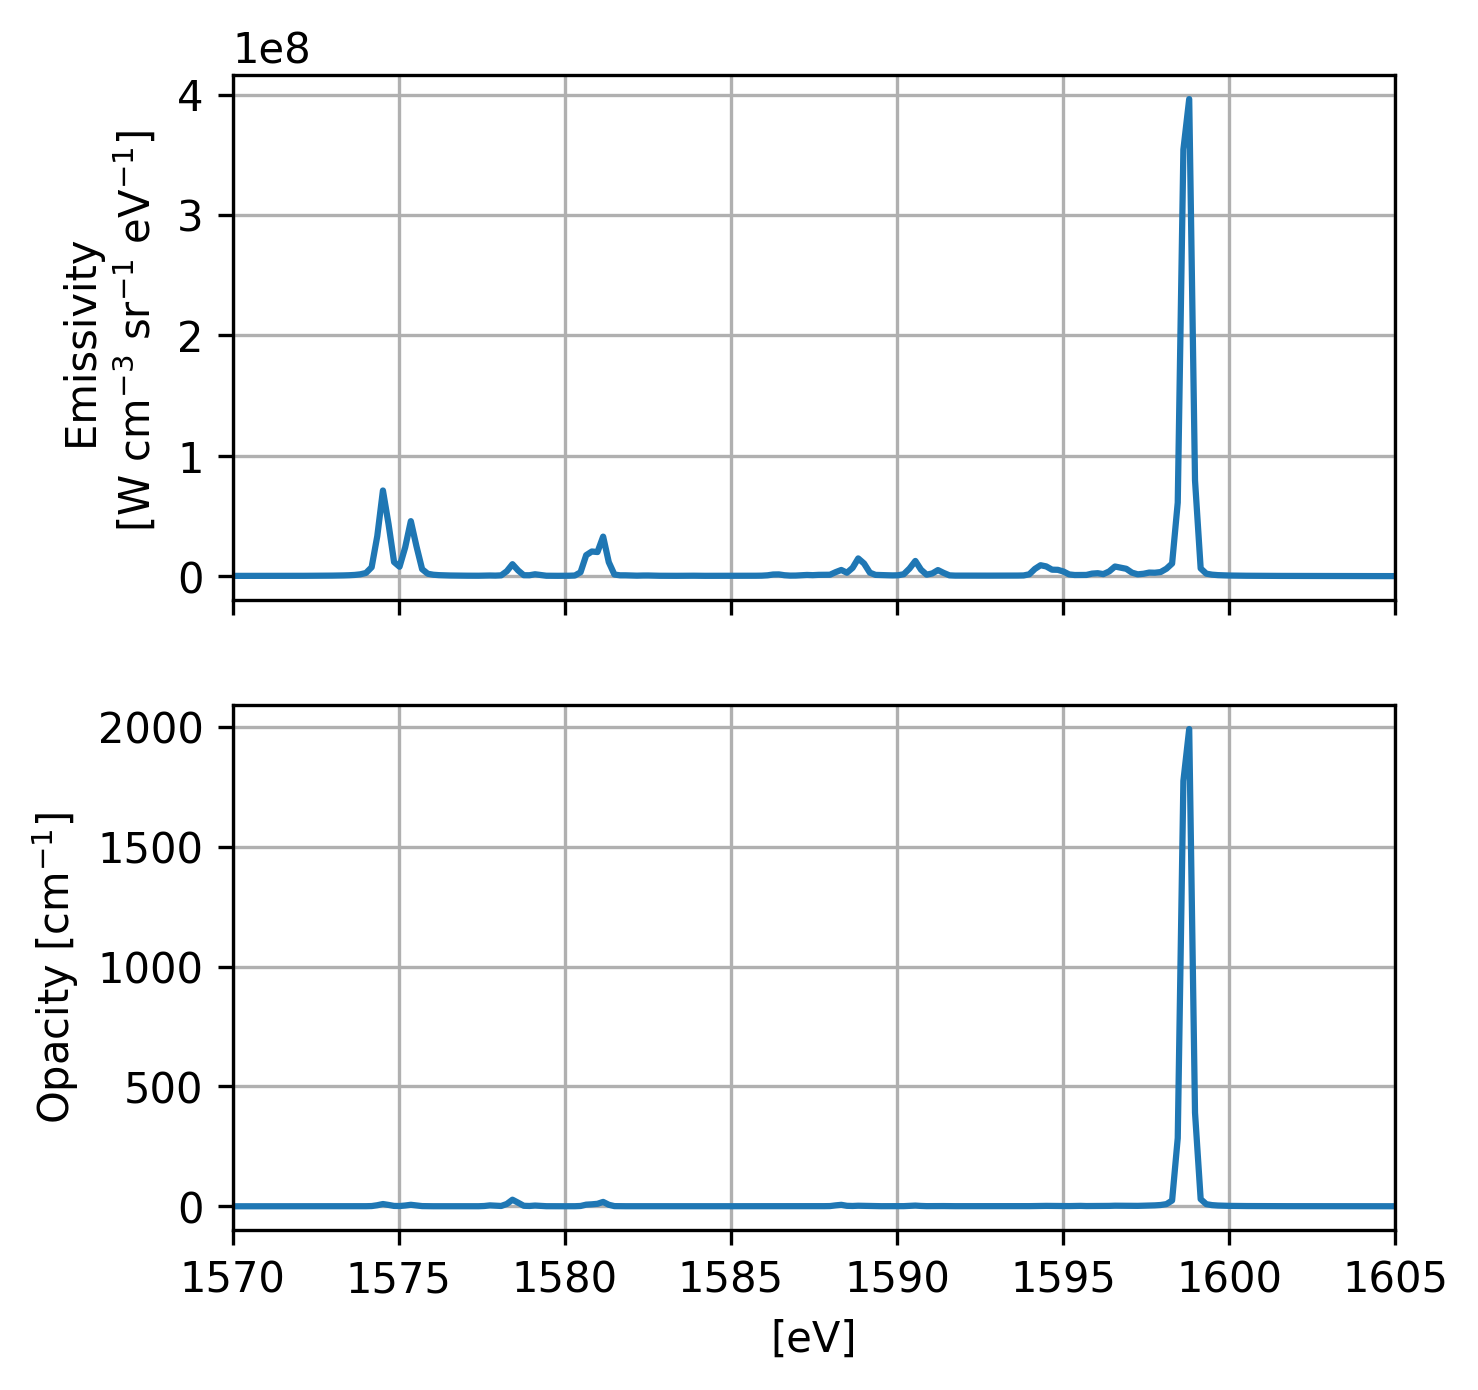

In [43]:
# new knr for emissivity
knr_emi = KNeighborsRegressor(n_neighbors=2,weights='distance')
knr_emi.fit(x_scale,y_emi)

# new knr for opacity

knr_opa = KNeighborsRegressor(n_neighbors=2,weights='distance')
knr_opa.fit(x_scale,y_opa)

def getEmi(ni,Te):
    ni = scale_ni(ni)
    Te = scale_T(Te)
    emi = knr_emi.predict(np.array([[ni,Te]])) # W/cm^3/sr/eV
    return emi[0]

def getOpa(ni,Te):
    ni = scale_ni(ni)
    Te = scale_T(Te)
    opa = knr_opa.predict(np.array([[ni,Te]])) # cm^-1
    return opa[0]

fig,axs = plt.subplots(2,1,figsize=(5,5),dpi=300,sharex=True)
ni = 1e19
Te = 100
emi = getEmi(ni,Te)
opa = getOpa(ni,Te)
axs[0].plot(E,emi)
axs[0].set_ylabel('Emissivity \n [W cm$^{-3}$ sr$^{-1}$ eV$^{-1}$]')

axs[1].plot(E,opa)
axs[1].set_ylabel('Opacity [cm$^{-1}$]')
axs[1].set_xlabel('[eV]')
axs[1].set_xlim([E.min(),E.max()])
axs[1].set_xlim([1570,1605])

for ii in range(axs.shape[0]):
    axs[ii].grid()


In [44]:
# Save the models

pickle.dump(knr_opa, open('./models/knr_scram_opa.sav', 'wb'))
pickle.dump(knr_emi, open('./models/knr_scram_emi.sav', 'wb'))